# 1DCNN code for damage localization

## Importing APIs

In [ ]:
#imports
import os
import zipfile
%matplotlib inline
import random 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv1D, MaxPooling1D, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical,plot_model
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Callbacks

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_acc')>0.99) and (logs.get('acc')>0.99) and (logs.get('val_loss')<0.07) and (logs.get('loss')<0.07):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()

In [4]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 5))

## Importing data

In [5]:
df = pd.read_csv('E:/PhD-MSR/OGWdataset/Guided_wave_basic_measurement_data/dataset/AllDatasets/combinedata/SHM_diff_filter.txt',header=None)
print(df.shape)

(22176, 13108)


## Plotting dataset

In [6]:
seqlen = df.shape[1]
dT = 1e-7
time = np.arange(0,(seqlen)*dT,dT)
print(time.shape)

(13108,)


In [7]:
sigwindow = 1e-3
idx1 = 1000
idx2 = 6100

7141


Text(0, 0.5, 'Norm Amplitude')

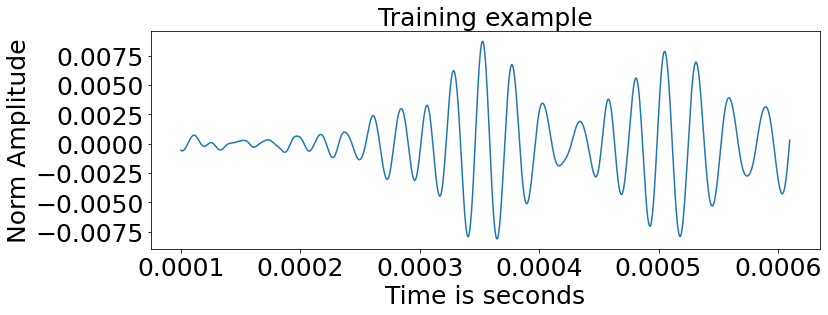

In [8]:
plt.figure(figsize=(12,4))
nn = random.randint(1,df.shape[0])
plt.plot(time[idx1:idx2], df.iloc[nn,idx1: idx2])
plt.title('Training example',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print(nn)
plt.xlabel('Time is seconds',fontsize=25)
plt.ylabel('Norm Amplitude',fontsize=25)

## Deciding Features and Labels

In [9]:
# to save RAM
#del freqtransch,transch,damtransch,A,B,X,y

In [10]:
# Using only transmission channels
sch1 = np.arange(6,11+1,1)                   # sub channels with 1 as actuator and other as sensors
sch2 = np.arange(16,21+1,1)                  # sub channels with 2 as actuator and other as sensors
sch3 = np.arange(25,30+1,1)
sch4 = np.arange(33,38+1,1)
sch5 = np.arange(40,45+1,1)
sch6 = np.arange(46,51+1,1)
transch = np.concatenate([sch1,sch2,sch3,sch4,sch5,sch6], axis=0)
freqtransch = np.concatenate([transch,transch+66,transch+66*2], axis=0)

A = []
for i in range(1,28,1):                       # we are incorporating all damages, i = 1 here means D2
    damtransch = 792*i + freqtransch      
    A.append(damtransch)

A = np.concatenate(A)                         # concatenate all appended vectors
B = np.concatenate([freqtransch,A],axis=0)    # concatenate D1 with D2 to D28
print(B.shape)
print(B)

(3024,)
[    6     7     8 ... 21565 21566 21567]


In [11]:
# Input/Features and labels extraction
X = df.iloc[B, idx1:idx2]
X = np.array(X)
X.shape

(3024, 5100)

1816


Text(0, 0.5, 'Norm Amplitude')

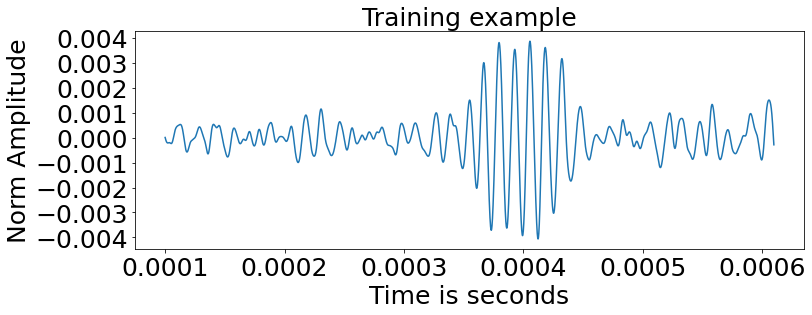

In [12]:
plt.figure(figsize=(12,4))
nn = random.randint(1,X.shape[0])
plt.plot(time[idx1:idx2], X[nn,0:X.shape[1]])
plt.title('Training example',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print(nn)
plt.xlabel('Time is seconds',fontsize=25)
plt.ylabel('Norm Amplitude',fontsize=25)

In [13]:
# Input/Features and labels extraction
# Baseline = 0
# Damage = 1
mclass = freqtransch.shape[0]*4
y1 = np.zeros((mclass,1), dtype=int)
y2 = np.ones((mclass,1), dtype=int)
y3 = y2*2
y4 = y2*3
y5 = y2*4
y6 = y2*5
y7 = y2*6

y = np.concatenate([y1,y2,y3,y4,y5,y6,y7], axis=0)
y = np.array(y)

y = to_categorical(y)
print(y.shape)

(3024, 7)


In [14]:
#del Xn1,n1,r,maxX

In [15]:
#---Random gaussian noise parameter
beta1 = 0.0025
beta2 = 0.003

mu = 0
sigma = 1

r = sigma*np.random.randn(X.shape[1],1) + mu   #random parameter with gaussian distribution
r = np.transpose(r)
print(r.shape)

#---Noisy signal
maxX = np.max(X)
maxX = np.array(maxX)
print(maxX.shape)

n1 = beta1*r*maxX
n2 = beta2*r*maxX
print(n2.shape)

Xn1 = X + n1
Xn2 = X + n2
print(Xn2.shape)

#---Signal to noise ratio
import math

rms_Xn = np.sqrt(np.mean(Xn2**2))
Power_Xn = rms_Xn**2
print(Power_Xn)

rms_n = np.sqrt(np.mean(n2**2))
Power_n = rms_n**2
print(Power_n)

SNR_dB = 10*math.log10(Power_Xn/Power_n)
print("SNR : ",SNR_dB)

(1, 5100)
()
(1, 5100)
(3024, 5100)
4.905745337030785e-06
2.447573484037756e-08
SNR :  23.01969260132006


In [16]:
Xn = np.concatenate([X,Xn1,Xn2], axis=0)
yn = np.concatenate([y,y,y], axis=0)
print(Xn.shape)
print(yn.shape)

(9072, 5100)
(9072, 7)


8253


Text(0.5, 1.0, 'Dam')

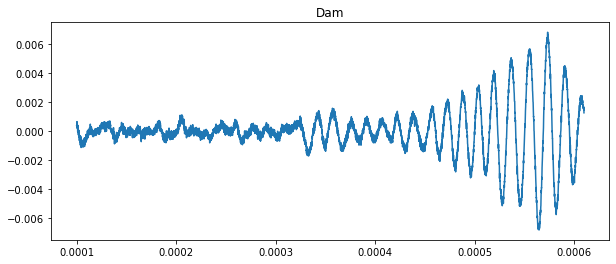

In [17]:
#---Plot non-noisy signal
D = random.randint(1, Xn.shape[0])
print(D)

plt.figure(figsize=(10,4))
plt.plot(time[idx1:idx2], Xn[D, 0 : Xn.shape[1]])
plt.title('Dam')

In [18]:
# Shapes of input and output
print(Xn.shape)
print(yn.shape)

(9072, 5100)
(9072, 7)


In [19]:
# https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8

## Splitting testing and test set

In [ ]:
#del model

In [44]:
# split into train and test
# Run this line of code for every run of the code if some parameters are changed
X1, X_test, y1, y_test = train_test_split(Xn,yn, test_size = 0.0005, random_state = 42)

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X1,y1, test_size = 0.1, random_state = 42)

In [46]:
# Shapes of training and test tests
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train = np.array(y_train)
y_train = np.array(y_train)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(8160, 5100)
(907, 5100)
(5, 5100)
(8160, 7)
(907, 7)
(5, 7)


## Reshape the arrays

In [47]:
# reshape the arrays
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_valid = np.reshape(X_valid, (X_valid.shape[0],X_valid.shape[1],1))
X_test  = np.reshape(X_test,  (X_test.shape[0],X_test.shape[1],1))

In [48]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
# print(y_train)

(8160, 5100, 1)
(907, 5100, 1)
(8160, 7)
(907, 7)


## Model Architecture

In [49]:
# define model architecture : 1DCNN-classification
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

Inp = Input(shape=(X.shape[1],1))

# Here i am trying multiscale CNN
# scale 1 = 3, scale 2 = 7
x1 = Sequential()

x1 = Conv1D(filters=16, kernel_size=3, input_shape=(X.shape[1],1))(Inp)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=64, kernel_size=3, activation='relu')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=256, kernel_size=3, activation='relu')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Flatten()(x1)

cnn1 = Model(Inp,x1)

In [50]:
from keras.layers import concatenate
#x = concatenate([cnn1.output,cnn2.output])
x = cnn1.output
#---------------------------------
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(7, activation='softmax')(x)
#---------------------------------
model = Model(inputs = Inp, outputs=x)

In [51]:
# summary of the model
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5100, 1)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5098, 16)          64        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 2549, 16)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2547, 32)          1568      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1273, 32)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1271, 64)          6208      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 635, 64)           0   

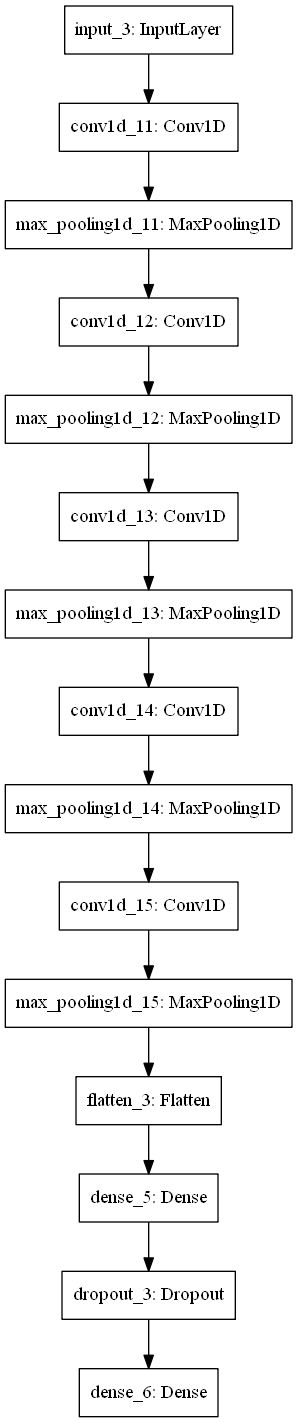

In [52]:
import keras
keras.utils.plot_model(model, "my_first_model.png")

In [53]:
# Functions for recall, precision and f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Choose Hyperparameters

In [54]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-5), metrics=['acc', precision_m, recall_m])

## Training

In [55]:
# train the model
# Here GPU fails. Before this line of code everything runs through i7 processor.
bsize = 64
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1000, batch_size = bsize, verbose=2, shuffle = True, callbacks = [epoch_schedule])

Train on 8160 samples, validate on 907 samples
Epoch 1/1000
 - 3s - loss: 1.9459 - acc: 0.1441 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9458 - val_acc: 0.1367 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/1000
 - 2s - loss: 1.9455 - acc: 0.1587 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9454 - val_acc: 0.1378 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/1000
 - 2s - loss: 1.9446 - acc: 0.1561 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9439 - val_acc: 0.1676 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/1000
 - 2s - loss: 1.9422 - acc: 0.1697 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9408 - val_acc: 0.1830 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 5/1000
 - 2s - loss: 1.9374 - acc: 0.1799 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9356 - val_acc: 0.1918 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+0

Epoch 47/1000
 - 3s - loss: 1.6263 - acc: 0.3556 - precision_m: 0.6964 - recall_m: 0.0581 - val_loss: 1.6762 - val_acc: 0.3153 - val_precision_m: 0.7756 - val_recall_m: 0.0496
Epoch 48/1000
 - 3s - loss: 1.6189 - acc: 0.3561 - precision_m: 0.7260 - recall_m: 0.0635 - val_loss: 1.6734 - val_acc: 0.3098 - val_precision_m: 0.7533 - val_recall_m: 0.0548
Epoch 49/1000
 - 3s - loss: 1.6131 - acc: 0.3681 - precision_m: 0.7046 - recall_m: 0.0625 - val_loss: 1.6656 - val_acc: 0.3208 - val_precision_m: 0.7649 - val_recall_m: 0.0548
Epoch 50/1000
 - 3s - loss: 1.6028 - acc: 0.3637 - precision_m: 0.7171 - recall_m: 0.0669 - val_loss: 1.6595 - val_acc: 0.3065 - val_precision_m: 0.7710 - val_recall_m: 0.0580
Epoch 51/1000
 - 3s - loss: 1.5963 - acc: 0.3763 - precision_m: 0.7124 - recall_m: 0.0724 - val_loss: 1.6545 - val_acc: 0.3252 - val_precision_m: 0.7660 - val_recall_m: 0.0559
Epoch 52/1000
 - 3s - loss: 1.5859 - acc: 0.3777 - precision_m: 0.7075 - recall_m: 0.0752 - val_loss: 1.6500 - val_acc: 

Epoch 94/1000
 - 3s - loss: 1.2661 - acc: 0.5309 - precision_m: 0.7487 - recall_m: 0.2644 - val_loss: 1.3767 - val_acc: 0.4653 - val_precision_m: 0.7180 - val_recall_m: 0.1840
Epoch 95/1000
 - 3s - loss: 1.2418 - acc: 0.5425 - precision_m: 0.7567 - recall_m: 0.2772 - val_loss: 1.3639 - val_acc: 0.4708 - val_precision_m: 0.7293 - val_recall_m: 0.2045
Epoch 96/1000
 - 3s - loss: 1.2352 - acc: 0.5400 - precision_m: 0.7551 - recall_m: 0.2765 - val_loss: 1.3584 - val_acc: 0.4697 - val_precision_m: 0.7258 - val_recall_m: 0.2005
Epoch 97/1000
 - 3s - loss: 1.2272 - acc: 0.5488 - precision_m: 0.7561 - recall_m: 0.2876 - val_loss: 1.3575 - val_acc: 0.4620 - val_precision_m: 0.7153 - val_recall_m: 0.2045
Epoch 98/1000
 - 3s - loss: 1.2259 - acc: 0.5515 - precision_m: 0.7439 - recall_m: 0.2853 - val_loss: 1.3417 - val_acc: 0.4851 - val_precision_m: 0.7278 - val_recall_m: 0.2117
Epoch 99/1000
 - 3s - loss: 1.2126 - acc: 0.5545 - precision_m: 0.7587 - recall_m: 0.2939 - val_loss: 1.3372 - val_acc: 

Epoch 141/1000
 - 3s - loss: 0.8287 - acc: 0.7071 - precision_m: 0.8300 - recall_m: 0.5544 - val_loss: 0.9579 - val_acc: 0.6692 - val_precision_m: 0.8394 - val_recall_m: 0.4688
Epoch 142/1000
 - 3s - loss: 0.8236 - acc: 0.7092 - precision_m: 0.8301 - recall_m: 0.5583 - val_loss: 0.9457 - val_acc: 0.6714 - val_precision_m: 0.8363 - val_recall_m: 0.4895
Epoch 143/1000
 - 3s - loss: 0.8153 - acc: 0.7135 - precision_m: 0.8309 - recall_m: 0.5656 - val_loss: 0.9471 - val_acc: 0.6736 - val_precision_m: 0.8263 - val_recall_m: 0.4876
Epoch 144/1000
 - 3s - loss: 0.7971 - acc: 0.7229 - precision_m: 0.8408 - recall_m: 0.5768 - val_loss: 0.9365 - val_acc: 0.6770 - val_precision_m: 0.8392 - val_recall_m: 0.4938
Epoch 145/1000
 - 3s - loss: 0.8028 - acc: 0.7167 - precision_m: 0.8282 - recall_m: 0.5768 - val_loss: 0.9342 - val_acc: 0.6759 - val_precision_m: 0.8350 - val_recall_m: 0.5009
Epoch 146/1000
 - 3s - loss: 0.8041 - acc: 0.7200 - precision_m: 0.8290 - recall_m: 0.5735 - val_loss: 0.9191 - val

Epoch 188/1000
 - 3s - loss: 0.4921 - acc: 0.8354 - precision_m: 0.8890 - recall_m: 0.7684 - val_loss: 0.5566 - val_acc: 0.8302 - val_precision_m: 0.9230 - val_recall_m: 0.7341
Epoch 189/1000
 - 3s - loss: 0.4781 - acc: 0.8474 - precision_m: 0.8988 - recall_m: 0.7795 - val_loss: 0.5512 - val_acc: 0.8346 - val_precision_m: 0.9228 - val_recall_m: 0.7497
Epoch 190/1000
 - 3s - loss: 0.4785 - acc: 0.8428 - precision_m: 0.8950 - recall_m: 0.7758 - val_loss: 0.5386 - val_acc: 0.8445 - val_precision_m: 0.9228 - val_recall_m: 0.7516
Epoch 191/1000
 - 3s - loss: 0.4694 - acc: 0.8474 - precision_m: 0.8981 - recall_m: 0.7800 - val_loss: 0.5268 - val_acc: 0.8479 - val_precision_m: 0.9211 - val_recall_m: 0.7508
Epoch 192/1000
 - 3s - loss: 0.4610 - acc: 0.8451 - precision_m: 0.8993 - recall_m: 0.7841 - val_loss: 0.5170 - val_acc: 0.8456 - val_precision_m: 0.9356 - val_recall_m: 0.7641
Epoch 193/1000
 - 3s - loss: 0.4546 - acc: 0.8507 - precision_m: 0.8974 - recall_m: 0.7900 - val_loss: 0.5216 - val

Epoch 235/1000
 - 3s - loss: 0.2810 - acc: 0.9099 - precision_m: 0.9352 - recall_m: 0.8853 - val_loss: 0.2639 - val_acc: 0.9416 - val_precision_m: 0.9744 - val_recall_m: 0.9146
Epoch 236/1000
 - 3s - loss: 0.2711 - acc: 0.9087 - precision_m: 0.9312 - recall_m: 0.8843 - val_loss: 0.2646 - val_acc: 0.9416 - val_precision_m: 0.9709 - val_recall_m: 0.9044
Epoch 237/1000
 - 3s - loss: 0.2718 - acc: 0.9174 - precision_m: 0.9379 - recall_m: 0.8893 - val_loss: 0.2563 - val_acc: 0.9504 - val_precision_m: 0.9724 - val_recall_m: 0.9127
Epoch 238/1000
 - 3s - loss: 0.2805 - acc: 0.9104 - precision_m: 0.9291 - recall_m: 0.8860 - val_loss: 0.2538 - val_acc: 0.9460 - val_precision_m: 0.9791 - val_recall_m: 0.9200
Epoch 239/1000
 - 3s - loss: 0.2690 - acc: 0.9130 - precision_m: 0.9348 - recall_m: 0.8910 - val_loss: 0.2484 - val_acc: 0.9504 - val_precision_m: 0.9780 - val_recall_m: 0.9302
Epoch 240/1000
 - 3s - loss: 0.2673 - acc: 0.9172 - precision_m: 0.9364 - recall_m: 0.8933 - val_loss: 0.2474 - val

Epoch 282/1000
 - 3s - loss: 0.1589 - acc: 0.9532 - precision_m: 0.9624 - recall_m: 0.9393 - val_loss: 0.1213 - val_acc: 0.9779 - val_precision_m: 0.9883 - val_recall_m: 0.9708
Epoch 283/1000
 - 3s - loss: 0.1582 - acc: 0.9495 - precision_m: 0.9582 - recall_m: 0.9376 - val_loss: 0.1200 - val_acc: 0.9791 - val_precision_m: 0.9957 - val_recall_m: 0.9708
Epoch 284/1000
 - 3s - loss: 0.1729 - acc: 0.9440 - precision_m: 0.9546 - recall_m: 0.9333 - val_loss: 0.1221 - val_acc: 0.9757 - val_precision_m: 0.9872 - val_recall_m: 0.9708
Epoch 285/1000
 - 3s - loss: 0.1567 - acc: 0.9537 - precision_m: 0.9627 - recall_m: 0.9427 - val_loss: 0.1164 - val_acc: 0.9724 - val_precision_m: 0.9894 - val_recall_m: 0.9698
Epoch 286/1000
 - 3s - loss: 0.1535 - acc: 0.9517 - precision_m: 0.9614 - recall_m: 0.9421 - val_loss: 0.1180 - val_acc: 0.9735 - val_precision_m: 0.9872 - val_recall_m: 0.9667
Epoch 287/1000
 - 3s - loss: 0.1556 - acc: 0.9526 - precision_m: 0.9621 - recall_m: 0.9415 - val_loss: 0.1181 - val

Epoch 329/1000
 - 3s - loss: 0.1052 - acc: 0.9658 - precision_m: 0.9704 - recall_m: 0.9604 - val_loss: 0.0755 - val_acc: 0.9934 - val_precision_m: 0.9958 - val_recall_m: 0.9937
Epoch 330/1000
 - 3s - loss: 0.1024 - acc: 0.9708 - precision_m: 0.9747 - recall_m: 0.9653 - val_loss: 0.0698 - val_acc: 0.9912 - val_precision_m: 0.9957 - val_recall_m: 0.9865
Epoch 331/1000
 - 3s - loss: 0.1062 - acc: 0.9665 - precision_m: 0.9730 - recall_m: 0.9614 - val_loss: 0.0643 - val_acc: 0.9956 - val_precision_m: 0.9958 - val_recall_m: 0.9865
Epoch 332/1000
 - 3s - loss: 0.1078 - acc: 0.9653 - precision_m: 0.9697 - recall_m: 0.9607 - val_loss: 0.0799 - val_acc: 0.9879 - val_precision_m: 0.9905 - val_recall_m: 0.9823
Epoch 333/1000
 - 3s - loss: 0.1048 - acc: 0.9675 - precision_m: 0.9729 - recall_m: 0.9630 - val_loss: 0.0753 - val_acc: 0.9912 - val_precision_m: 0.9916 - val_recall_m: 0.9865
Epoch 334/1000
 - 3s - loss: 0.1176 - acc: 0.9640 - precision_m: 0.9692 - recall_m: 0.9581 - val_loss: 0.0725 - val

Epoch 376/1000
 - 3s - loss: 0.0729 - acc: 0.9788 - precision_m: 0.9824 - recall_m: 0.9766 - val_loss: 0.0504 - val_acc: 0.9901 - val_precision_m: 0.9937 - val_recall_m: 0.9906
Epoch 377/1000
 - 3s - loss: 0.0723 - acc: 0.9794 - precision_m: 0.9827 - recall_m: 0.9752 - val_loss: 0.0454 - val_acc: 0.9967 - val_precision_m: 0.9969 - val_recall_m: 0.9969
Epoch 378/1000
 - 3s - loss: 0.0727 - acc: 0.9781 - precision_m: 0.9814 - recall_m: 0.9741 - val_loss: 0.0563 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 379/1000
 - 3s - loss: 0.0776 - acc: 0.9767 - precision_m: 0.9793 - recall_m: 0.9736 - val_loss: 0.0506 - val_acc: 0.9923 - val_precision_m: 0.9927 - val_recall_m: 0.9927
Epoch 380/1000
 - 3s - loss: 0.0747 - acc: 0.9768 - precision_m: 0.9802 - recall_m: 0.9738 - val_loss: 0.0505 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9906
Epoch 381/1000
 - 3s - loss: 0.0756 - acc: 0.9773 - precision_m: 0.9799 - recall_m: 0.9741 - val_loss: 0.0471 - val

Epoch 423/1000
 - 3s - loss: 0.0590 - acc: 0.9812 - precision_m: 0.9838 - recall_m: 0.9799 - val_loss: 0.0466 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 424/1000
 - 3s - loss: 0.0633 - acc: 0.9810 - precision_m: 0.9832 - recall_m: 0.9788 - val_loss: 0.0432 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 425/1000
 - 3s - loss: 0.0532 - acc: 0.9838 - precision_m: 0.9856 - recall_m: 0.9823 - val_loss: 0.0379 - val_acc: 0.9967 - val_precision_m: 0.9969 - val_recall_m: 0.9969
Epoch 426/1000
 - 3s - loss: 0.0536 - acc: 0.9827 - precision_m: 0.9848 - recall_m: 0.9814 - val_loss: 0.0534 - val_acc: 0.9967 - val_precision_m: 0.9969 - val_recall_m: 0.9937
Epoch 427/1000
 - 3s - loss: 0.0613 - acc: 0.9805 - precision_m: 0.9827 - recall_m: 0.9786 - val_loss: 0.0442 - val_acc: 0.9967 - val_precision_m: 0.9989 - val_recall_m: 0.9969
Epoch 428/1000
 - 3s - loss: 0.0576 - acc: 0.9822 - precision_m: 0.9833 - recall_m: 0.9800 - val_loss: 0.0500 - val

Epoch 470/1000
 - 3s - loss: 0.0479 - acc: 0.9857 - precision_m: 0.9870 - recall_m: 0.9849 - val_loss: 0.0365 - val_acc: 0.9967 - val_precision_m: 0.9969 - val_recall_m: 0.9969
Epoch 471/1000
 - 3s - loss: 0.0445 - acc: 0.9860 - precision_m: 0.9871 - recall_m: 0.9849 - val_loss: 0.0443 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 472/1000
 - 3s - loss: 0.0444 - acc: 0.9857 - precision_m: 0.9871 - recall_m: 0.9840 - val_loss: 0.0470 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 473/1000
 - 3s - loss: 0.0429 - acc: 0.9865 - precision_m: 0.9883 - recall_m: 0.9854 - val_loss: 0.0422 - val_acc: 0.9945 - val_precision_m: 0.9948 - val_recall_m: 0.9948
Epoch 474/1000
 - 3s - loss: 0.0430 - acc: 0.9864 - precision_m: 0.9877 - recall_m: 0.9850 - val_loss: 0.0441 - val_acc: 0.9934 - val_precision_m: 0.9937 - val_recall_m: 0.9937
Epoch 475/1000
 - 3s - loss: 0.0493 - acc: 0.9859 - precision_m: 0.9869 - recall_m: 0.9846 - val_loss: 0.0423 - val

## Plot Accuracy and Loss

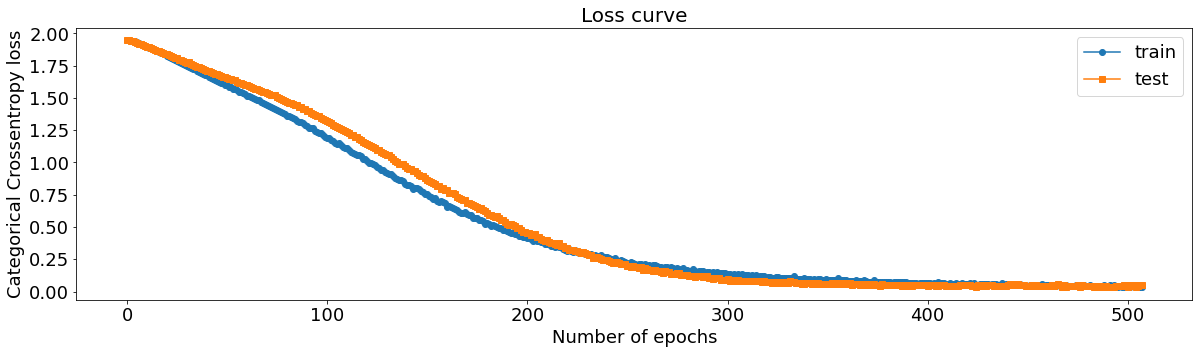

In [56]:
#---Summarize history for loss
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-s')
plt.title('Loss Curve',fontsize=20)
plt.ylabel('Loss',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

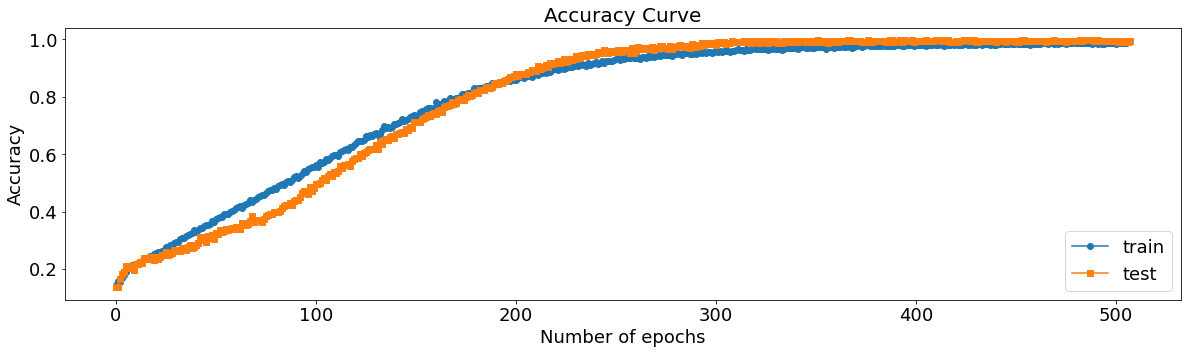

In [57]:
#---Summarize history for accuracy---
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-s')
plt.title('Accuracy Curve',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

### Output of final layer

In [ ]:
# trained model weights
layer_outputs = model.layers[6].output
print(layer_outputs.shape)
print(layer_outputs)

### Weights and biases of any layer

In [ ]:
layer_weights = model.layers[0].get_weights()[0]
print(layer_weights.shape)
print(layer_weights)

In [ ]:
layer_biases  = model.layers[0].get_weights()[1]
print(layer_biases.shape)
print(layer_biases)

### Predictions

In [58]:
from sklearn.utils.multiclass import unique_labels
import itertools
import matplotlib.pyplot as plt
from keras.utils import to_categorical

fig = plt.gcf()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
      horizontalalignment = 'center',
      color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

In [59]:
y_predicted = model.predict(X_valid, verbose = 2)
y_actual = y_valid

y_predict = model.predict(X_valid, verbose = 2)
y_predict = np.argmax(y_predict, axis=1)

y_act = np.argmax(y_valid, axis=1)  # converting one hot representation back to numerical data

cm = confusion_matrix(y_act, y_predict)

Confusion matrix, without normalization
[[129   0   0   0   0   0   0]
 [  0 134   0   0   0   0   0]
 [  0   0 113   0   0   0   0]
 [  0   0   3 136   0   0   0]
 [  0   0   0   0 124   0   0]
 [  0   0   0   0   0 131   0]
 [  0   0   3   0   0   0 134]]


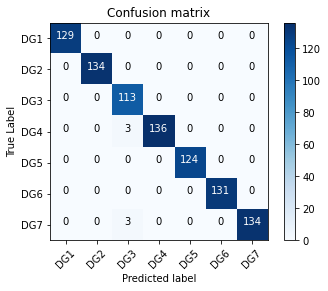

In [60]:
# Plot Non-Normalized confusion matrix
cm_labels = ['DG1','DG2','DG3','DG4','DG5','DG6','DG7']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.98 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.98]]


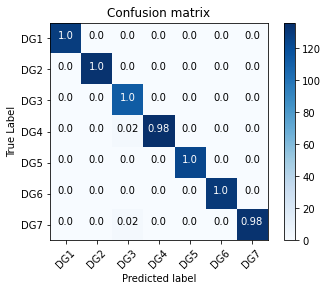

In [61]:
# Plot Normalized confusion matrix
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

In [62]:
# Classification Report
print('Classification Report')
print(classification_report(y_act, y_predict, target_names = cm_labels))

Classification Report
              precision    recall  f1-score   support

         DG1       1.00      1.00      1.00       129
         DG2       1.00      1.00      1.00       134
         DG3       0.95      1.00      0.97       113
         DG4       1.00      0.98      0.99       139
         DG5       1.00      1.00      1.00       124
         DG6       1.00      1.00      1.00       131
         DG7       1.00      0.98      0.99       137

    accuracy                           0.99       907
   macro avg       0.99      0.99      0.99       907
weighted avg       0.99      0.99      0.99       907



### AUC-ROC curve

In [63]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_actual[:, i], np.round(y_predicted[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [64]:
print(fpr)

{0: array([0., 0., 1.]), 1: array([0., 0., 1.]), 2: array([0.        , 0.00755668, 1.        ]), 3: array([0., 0., 1.]), 4: array([0., 0., 1.]), 5: array([0., 0., 1.]), 6: array([0., 0., 1.])}


In [65]:
print(tpr)

{0: array([0., 1., 1.]), 1: array([0., 1., 1.]), 2: array([0., 1., 1.]), 3: array([0.        , 0.97841727, 1.        ]), 4: array([0., 1., 1.]), 5: array([0., 1., 1.]), 6: array([0.        , 0.97810219, 1.        ])}


In [66]:
print(roc_auc)

{0: 1.0, 1: 1.0, 2: 0.9962216624685138, 3: 0.9892086330935252, 4: 1.0, 5: 1.0, 6: 0.9890510948905109}


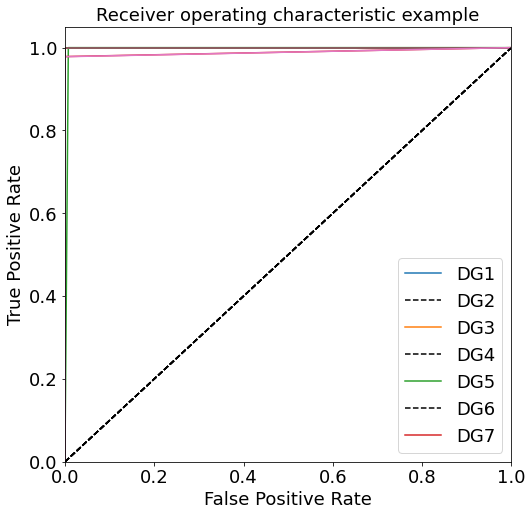

In [67]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(8,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver operating characteristic example',fontsize=18)
    plt.legend(cm_labels,loc="lower right",fontsize=18)